<a href="https://colab.research.google.com/github/ruheyun/python_pytorch/blob/main/Vision_Transformer(ViT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 导入库
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch import Tensor
from PIL import Image
# from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
%matplotlib inline

In [ ]:
# 对训练数据使用数据增强方法 以便提升模型的泛化能力
train_transform= transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2435, 0.2616])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2435, 0.2616])
])

In [ ]:
# 导入数据
train_set = torchvision.datasets.CIFAR10(root='/kaggle/working/data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_set = torchvision.datasets.CIFAR10(root='/kaggle/working/data', train=False, download= False, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


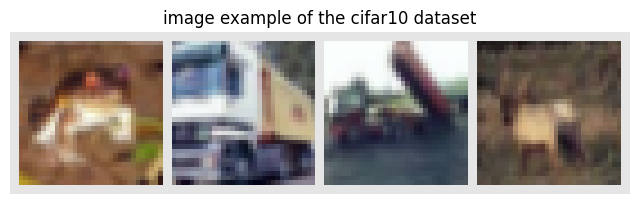

In [ ]:
# 可视化数据
num_images = 4
cifar_images = torch.stack([train_set[idx][0] for idx in range(num_images)], dim=0)
img_grid = torchvision.utils.make_grid(cifar_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(8, 8))
plt.title('image example of the cifar10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
# 将图片切成多个分片并展平 、添加分类标记、位置嵌入
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_size=256, img_size=32):
        super().__init__()
        self.projection = nn.Sequential(
            # Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            # nn.Linear(patch_size * patch_size * in_channels, emb_size)
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e h w -> b (h w) e')
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.position = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.position
        return x

In [ ]:
# 多头注意力
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=256, num_heads=8, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        self.emb_size = emb_size
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x, mask=None):
        qkv = rearrange(self.qkv(x), 'b n (h d qkv) -> (qkv) b h n d', h=self.num_heads, qkv=3)
        q, k, v = qkv[0], qkv[1], qkv[2]
        energy = torch.einsum('bhqd, bhkd -> bhqk', q, k)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)

        out = torch.einsum('bhal, bhlv -> bhav', att, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out

In [ ]:
# 残差连接
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
# 前馈神经网络
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size=256, expansion=4, drop_p=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [ ]:
# 构建编码器块
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size=256, drop_p=0., forward_expansion=4, forward_drop_p=0., **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )

In [ ]:
# 构建整个编码器
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [ ]:
# 构建输出头
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=256, n_classes=10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

In [ ]:
# 构建vit架构
class ViT(nn.Sequential):
    def __init__(self, in_channels=3, patch_size=4, emb_size=256, img_size=32, depth=12, n_classes=10, **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit.parameters(), lr=1e-3)

In [ ]:
for epoch in range(100):
    running_loss = 0
    running_acc = 0
    vit.train()
    for i, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        out = vit(data)
        optimizer.zero_grad()
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        _, pres = out.max(1)
        acc = (pres == label).sum().item() / len(label)
        running_acc += acc
        running_loss += loss.item()

    vit.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            out = vit(data)
            loss = criterion(out, label)
            _, pres = out.max(1)
            acc = (pres == label).sum().item() / len(label)
            test_acc += acc
            test_loss += loss
    print(f'epoch: [{epoch}], train_loss: [{running_loss / len(train_loader):.3f}], train_acc: [{running_acc / len(train_loader):.3f}], test_loss: [{test_loss / len(test_loader):.3f}], test_acc: [{test_acc / len(test_loader):.3f}]')

epoch: [0], train_loss: [1.873], train_acc: [0.294], test_loss: [1.599], test_acc: [0.407]
epoch: [1], train_loss: [1.524], train_acc: [0.438], test_loss: [1.397], test_acc: [0.488]
epoch: [2], train_loss: [1.425], train_acc: [0.482], test_loss: [1.388], test_acc: [0.495]
epoch: [3], train_loss: [1.439], train_acc: [0.475], test_loss: [1.501], test_acc: [0.458]
epoch: [4], train_loss: [1.464], train_acc: [0.466], test_loss: [1.422], test_acc: [0.483]
epoch: [5], train_loss: [1.449], train_acc: [0.474], test_loss: [1.585], test_acc: [0.420]
epoch: [6], train_loss: [1.472], train_acc: [0.466], test_loss: [1.376], test_acc: [0.500]
epoch: [7], train_loss: [1.422], train_acc: [0.485], test_loss: [1.384], test_acc: [0.504]
epoch: [8], train_loss: [1.403], train_acc: [0.491], test_loss: [1.351], test_acc: [0.512]
epoch: [9], train_loss: [1.430], train_acc: [0.482], test_loss: [1.371], test_acc: [0.501]
epoch: [10], train_loss: [1.380], train_acc: [0.500], test_loss: [1.392], test_acc: [0.495